# Lab 7 - Naive Bayes
- **Author:** Dimitris Papadimitriou ([dimitri@berkeley.edu](mailto:dimitri@berkeley.edu))
- **Date:** 18 March 2020
- **Course:** INFO 251: Applied Machine Learning

### Topics:
1. Naive Bayes with text data
2. Decision trees and random forests in Python
3. AdaBoost and gradient boosting

### References: 
 * [Ham vs Spam](https://appliedmachinelearning.wordpress.com/2017/01/23/email-spam-filter-python-scikit-learn/)
 * [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
 * [multinomial Naive Bayes classifier](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 * [Sparse Matrices Scipy](https://en.wikipedia.org/wiki/Sparse_matrix)

In [47]:
import os
import numpy as np
from collections import Counter
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix 
import IPython

# 1. Naive Bayes Intro

First we go over feature generation for NB Bernoulli and NB Multinomial

-- alpha ==> default 1 for  smoothing 0 otherwise

-- binarize ==>  threshold to binarize features

-- class_prior ==>  Can specify custom priors

-- fit_prior ==>  (True/False) Estimate or not the prior


In [43]:
# Bernoulli NB (as in class)
X = np.random.randint(2, size=(6, 100))# features
Y = np.array([1, 0, 1, 1, 1, 0])# labels
clf = BernoulliNB()
clf.fit(X, Y)
#BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
print(clf.predict(X[2:3]))
print(clf.predict_proba(X[2:3]))
print(clf.get_params())

[1]
[[8.0153680e-08 9.9999992e-01]]
{'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}


In [45]:
# Multinomial NB (as in class)
rng = np.random.RandomState(1)
X = rng.randint(5, size=(6, 100))
y = np.array([1, 0, 0, 1, 1, 1])
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X, y)
print(clf.predict(X[2:3]))
print(X.shape)
print(clf.predict_proba(X))

[0]
(6, 100)
[[1.54776713e-13 1.00000000e+00]
 [1.00000000e+00 3.01096168e-19]
 [1.00000000e+00 2.41724590e-17]
 [1.59053096e-16 1.00000000e+00]
 [1.25834403e-16 1.00000000e+00]
 [2.30942149e-14 1.00000000e+00]]


In [49]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is\n", '\n'.join(text))
print()
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)
# Compressed sparse row
# print(x)

# CountVectorizer uses a sparse array to save memory
# convert back to a "normal" numpy array
x = x.toarray()

print("Transformed text vector is \n", x)
print()
# `get_feature_names` tracks which word is associated with each column of the transformed x
print("Words for each feature:")
print(vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


## step 1: create word dictionary

In [5]:
a = []
for i in [1,2,3,4]:
    if i > 3:
        a.append(str(i+10))

In [6]:
a = [str(i+10) for i in [1,2,3,4] if i > 3]

In [7]:
a = os.listdir(train_dir)[0]
a

'ham_0.txt'

In [8]:
os.path.join('mails/train/', a)

'mails/train/ham_0.txt'

In [9]:
train_dir + a

'mails/trainham_0.txt'

In [10]:
a = [os.path.join(train_dir,f) for f in os.listdir(train_dir)][0]
a

'mails/train\\ham_0.txt'

In [11]:
os.path.basename(a)

'ham_0.txt'

In [12]:
a[12:]

'ham_0.txt'

In [13]:
def make_dictionary(train_dir):
    # Return a list containing the names of the entries in the directory given by path. 
    emails = [os.path.join(train_dir,f) for f in os.listdir(train_dir)]    
    all_words = []       
    for mail in emails:    
        with open(mail) as m:
            for i,line in enumerate(m):
                words = line.split(' ')
                all_words += words

    dictionary = Counter(all_words)
    list_to_remove = list(dictionary.keys())
    for item in list_to_remove:
        # remove 'a', '.', ...
        # you can use more advanced functions to remove stopping words.
        if len(item) == 1:
            del dictionary[item]
            
    dictionary = dictionary.most_common(3000)
    return dictionary

## step 2: create features

In [14]:
def extract_features(mail_dir): 
    files = [os.path.join(mail_dir,fi) for fi in os.listdir(mail_dir)]
    features_matrix = np.zeros((len(files),3000))
    docID = 0
    label = []
    for fil in files:
        if os.path.basename(fil)[:3] == 'ham':
            label.append(1)
        else:
            label.append(0)
        with open(fil) as fi:
            f = fi.read()
            words = f.strip('\n').split()
            for i,d in enumerate(dictionary):
                wordID = i
                features_matrix[docID,wordID] += words.count(d[0])
        docID = docID + 1     
    return features_matrix, np.array(label)

In [15]:
dictionary = make_dictionary(train_dir)

In [16]:
train_x, train_y = extract_features(train_dir)
test_x, test_y = extract_features(test_dir)
print(train_x)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 8.  8.  0. ...  0.  0.  0.]
 [24. 16.  0. ...  0.  0.  0.]
 ...
 [ 4.  5.  0. ...  0.  0.  0.]
 [ 2.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


## step 3: train the model

In [9]:
model1 = MultinomialNB()
model1.fit(train_x, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
# get accuracy of testing set
print(model1.score(test_x, test_y))

0.9718592964824121


In [11]:
# get confusion matrix
result1 = model1.predict(test_x)
print(confusion_matrix(test_y, result1))

[[485  10]
 [ 18 482]]


In binary classification, the count of true negatives is $C_{0,0}$, false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$.

false negative is? meaning?

# 2. Custom Dictionary

We will use the dataset of [enron-spam](http://www2.aueb.gr/users/ion/data/enron-spam/) to detect spams.

In [ ]:
train_dir = 'mails/train'
test_dir = 'mails/test'

In [ ]:
len(os.listdir(train_dir))

In [ ]:
len(os.listdir(test_dir))

# 2. Random forest

In [12]:
model2 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10)

Other parameters
- min_samples_split=2
- min_samples_leaf=1
- min_impurity_decrease=0.0
- n_jobs=None

In [13]:
model2.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
print(model2.score(test_x, test_y))

0.9457286432160804


In [15]:
f_imp = model2.feature_importances_
print(f_imp)

[0.00827482 0.00456007 0.         ... 0.         0.         0.        ]


In [16]:
word = [d[0] for d in dictionary]
word = np.array(word)
word

array(['the', 'to', '.\n', ..., 'hayward\n', 'stumpage', 'tonk'],
      dtype='<U16')

In [40]:
a = [1, 2, 3, 6, 5, 4]
a[::-1]

[4, 5, 6, 3, 2, 1]

In [17]:
f_imp_order = np.argsort(f_imp)
word[f_imp_order[-10:]]

array(['attached', 'pm', 'daren', 'gas', 'meter', 'thanks', 'cc',
       'forwarded', 'enron', '2000'], dtype='<U16')

In [18]:
from sklearn import tree

In [19]:
# install graphviz: pip install graphviz
# brew install graphviz
import graphviz 

In [20]:
dot_data = tree.export_graphviz(model2.estimators_[10], out_file=None, 
                         feature_names=word,  
                         class_names=['ham', 'spam'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 

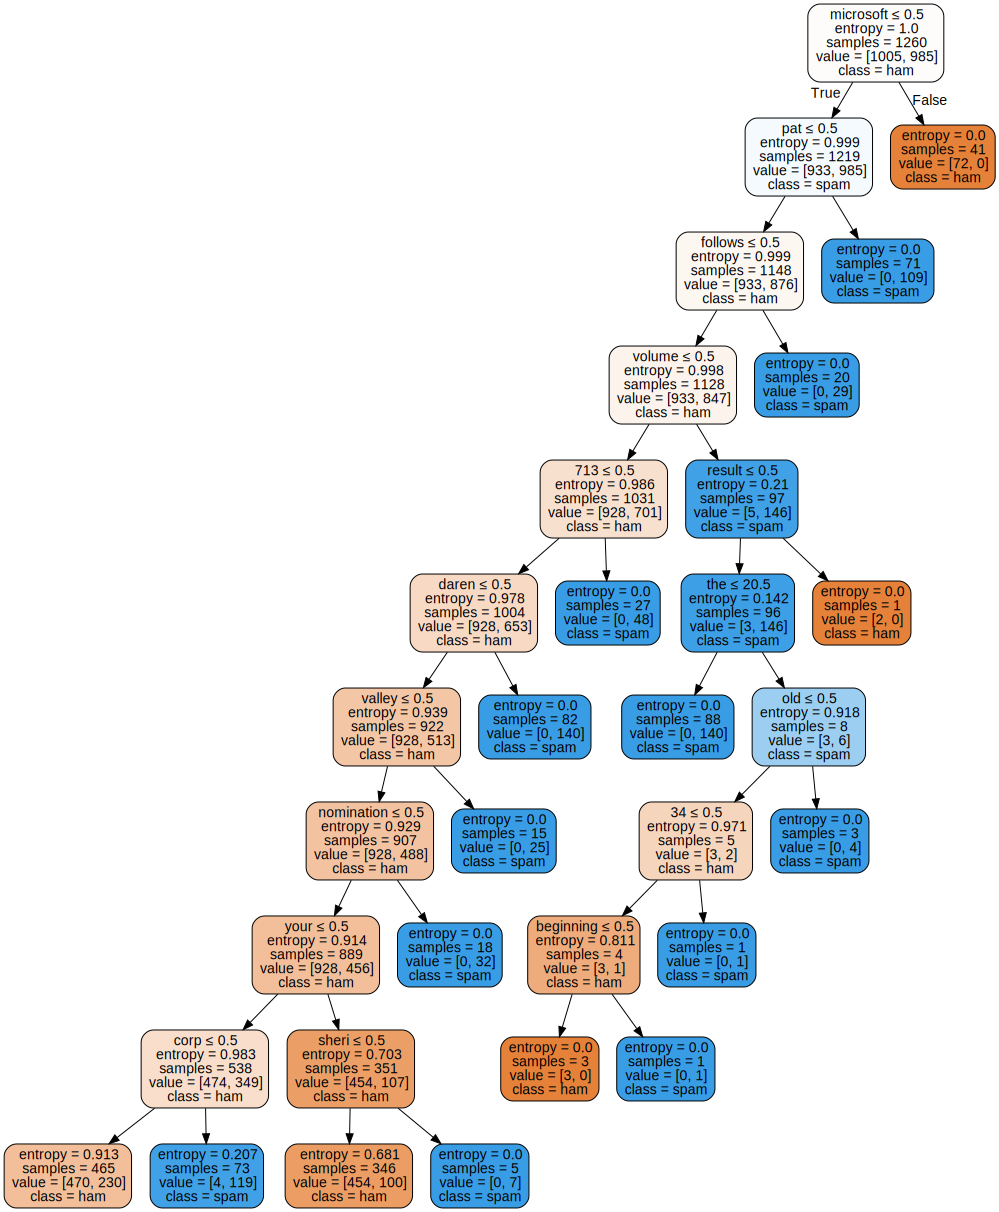

In [21]:
graph

Questions:
1. Why is the sum of values not equal to the sample?

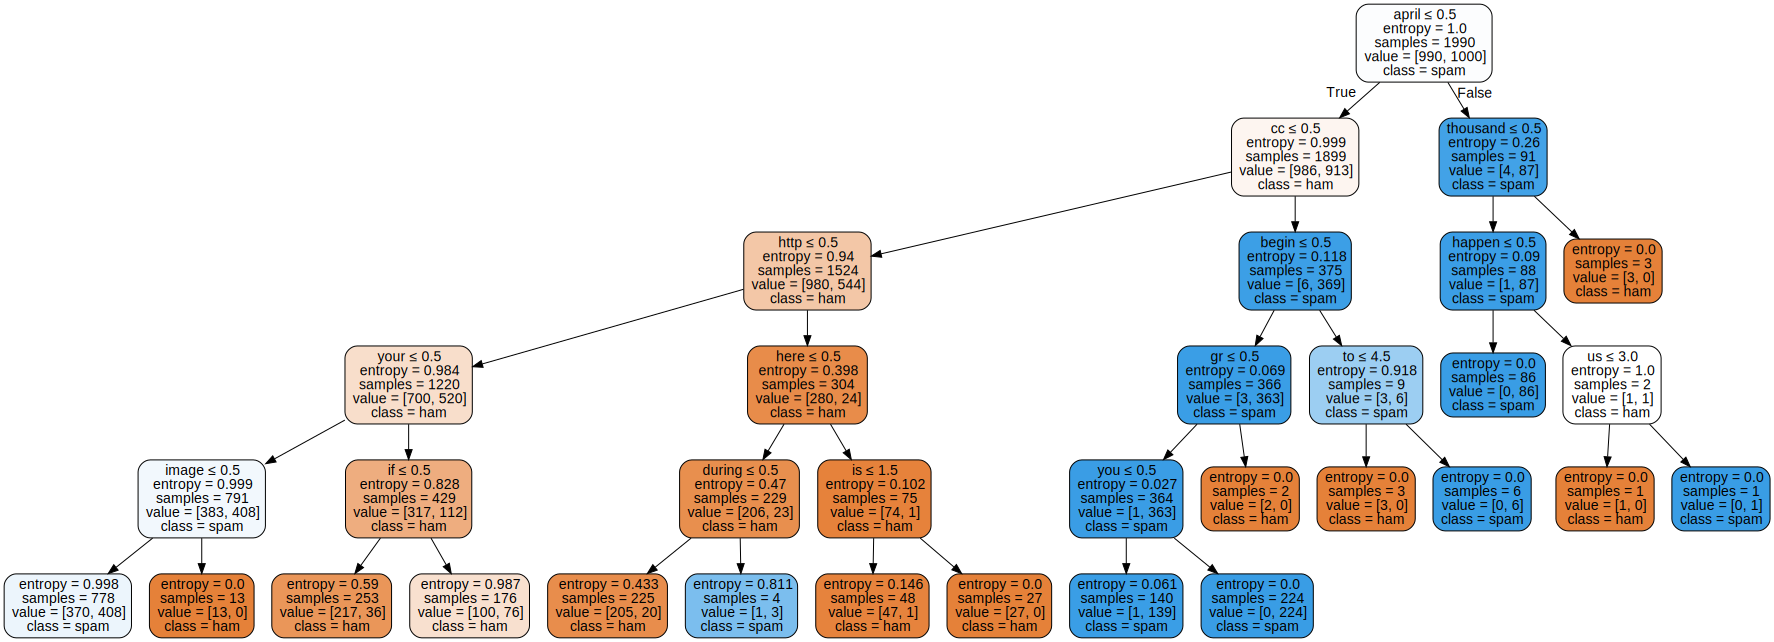

In [22]:
model3 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=5, bootstrap=False)
model3.fit(train_x,train_y)
dot_data = tree.export_graphviz(model3.estimators_[10], out_file=None, 
                         feature_names=word,  
                         class_names=['ham', 'spam'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph